In [1]:
pip install pymorphy2

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
# import other required libs
import pandas as pd
import numpy as np
import pymorphy2 as pm
import nltk

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
import re
from tqdm.notebook import tqdm
import multiprocessing
from multiprocessing import Pool
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)

print('cores:', N_CORES)
pd.set_option('display.max_colwidth', 100)

cores: 10


## Bachelors group

In [5]:
df = pd.read_csv('profile_info_gsom_bach.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3431 non-null   int64  
 1   id                  3431 non-null   int64  
 2   first_name          3431 non-null   object 
 3   last_name           3189 non-null   object 
 4   university_name     501 non-null    object 
 5   education_status    192 non-null    object 
 6   sex                 3431 non-null   int64  
 7   interests           89 non-null     object 
 8   bdate               2729 non-null   object 
 9   city_id             2500 non-null   float64
 10  city_title          2500 non-null   object 
 11  last_seen_platform  3030 non-null   float64
 12  last_seen_time      3030 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 348.6+ KB


In [7]:
df.head(2)

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
0,0,959,Anna,Chaykina,NaN,NaN,1,NaN,25.4,2.0,Saint Petersburg,4.0,2023-05-01 22:05:44
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,24.7.1983,2.0,Saint Petersburg,2.0,2023-05-01 18:20:25


In [8]:
df = df.loc[df['last_seen_time'] >= '2022-06-01']

In [9]:
df = df.loc[df['bdate'].str.len() == 9]

In [10]:
curr_time = pd.to_datetime("now")
print(curr_time)

2023-05-21 19:20:49.098711


/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [11]:
df['bdate'] = pd.to_datetime(df.bdate, format='%d.%m.%Y')

In [12]:
df.head(2)

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,1983-07-24,2.0,Saint Petersburg,2.0,2023-05-01 18:20:25
3,3,9088,Sergey,Cherepanov,NaN,NaN,2,NaN,1989-08-23,2.0,Saint Petersburg,4.0,2023-05-01 20:05:44


In [13]:
df.city_title.value_counts()

Saint Petersburg    253
Moscow               45
Novosibirsk           8
Krasnoyarsk           7
Izhevsk               5
                   ... 
Little Tokyo          1
Berlin                1
Stavropol             1
Odessa                1
Penza                 1
Name: city_title, Length: 85, dtype: int64

In [14]:
Conditions = [
    (df['city_title'] == 'Saint Petersburg'),
    (df['city_title'] == 'Moscow'),
    (df['city_title'] != 'Saint Petersburg')& (df['city_title'] != 'Moscow')
]
Categories = ['0', '1', '2']
df['city'] = np.select(Conditions, Categories)
#print(df)

In [15]:
df.city.value_counts()

2    269
0    253
1     45
Name: city, dtype: int64

In [16]:
df['diff_days'] = curr_time - df['bdate']
# for days use 'D' for weeks use 'W', for month use 'M' and for years use 'Y'
df['years_old']=df['diff_days']/np.timedelta64(1,'Y')      
print(df)

      Unnamed: 0         id first_name   last_name university_name  \
1              1       1361       Anna    Veselova             NaN   
3              3       9088     Sergey  Cherepanov             NaN   
6              6      18619       Oleg      Koresh             NaN   
9              9      38445      Alina    Borodina             NaN   
14            14      73458      Maria    Smirnova             NaN   
...          ...        ...        ...         ...             ...   
3408        3408  744131146       Anna      Ermeni           СПбГУ   
3409        3409  744825520       Ivan     Bushuev             NaN   
3410        3410  745902835       Madi        Xoja             NaN   
3428        3428  776095130       Rudi       Troya             NaN   
3429        3429  787319478    Valeria  Shevchenko             NaN   

     education_status  sex interests      bdate  city_id        city_title  \
1                 NaN    1       NaN 1983-07-24      2.0  Saint Petersburg   
3  

## Clustering bachelor

In [17]:
df_profile = df[["sex", "years_old", 'city']]

### DBSCAN 

### scaling and normalizing the dataset


In [18]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
df_profile[['years_old']] = scaler.fit_transform(df_profile[['years_old']])

/tmp/ipykernel_339/2130169438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_profile[['years_old']] = scaler.fit_transform(df_profile[['years_old']])


In [19]:
df_profile = pd.get_dummies(df_profile, columns=["sex","city"])

In [20]:
df_profile

,years_old,sex_1,sex_2,city_0,city_1,city_2
1,0.233271,1,0,1,0,0
3,0.176456,0,1,1,0,0
6,0.197499,0,1,1,0,0
9,0.181109,1,0,1,0,0
14,0.262062,1,0,1,0,0
...,...,...,...,...,...,...
3408,0.045539,1,0,1,0,0
3409,0.036258,0,1,0,0,1
3410,0.046051,1,0,0,0,1
3428,0.079215,0,1,0,0,1


In [21]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(df_profile)
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [130]:
dbscan = DBSCAN(eps=0.035, min_samples=10).fit(df_profile)
labels = dbscan.labels_
df['cluster'] = dbscan.labels_
print(df.tail())
 

      Unnamed: 0         id first_name   last_name university_name  \
3408        3408  744131146       Anna      Ermeni           СПбГУ   
3409        3409  744825520       Ivan     Bushuev             NaN   
3410        3410  745902835       Madi        Xoja             NaN   
3428        3428  776095130       Rudi       Troya             NaN   
3429        3429  787319478    Valeria  Shevchenko             NaN   

     education_status  sex interests      bdate  city_id        city_title  \
3408              NaN    1       NaN 2003-08-30      2.0  Saint Petersburg   
3409              NaN    2       NaN 2004-08-27      NaN               NaN   
3410              NaN    1       NaN 2003-08-10      NaN               NaN   
3428              NaN    2       NaN 2000-01-21      NaN               NaN   
3429              NaN    1       NaN 2006-03-30      NaN               NaN   

      last_seen_platform       last_seen_time city                 diff_days  \
3408                 4.0  2023

In [131]:
# assign clusters and pca vectors to our dataframe 
df['x0'] = x0
df['x1'] = x1

In [132]:
df.head(3)

,Unnamed: 0,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time,city,diff_days,years_old,cluster,x0,x1
1,1,1361,Anna,Veselova,NaN,NaN,1,NaN,1983-07-24,2.0,Saint Petersburg,2.0,2023-05-01 18:20:25,0,14546 days 19:20:49.098711,39.827802,0,0.746275,-0.369992
3,3,9088,Sergey,Cherepanov,NaN,NaN,2,NaN,1989-08-23,2.0,Saint Petersburg,4.0,2023-05-01 20:05:44,0,12324 days 19:20:49.098711,33.744173,3,0.673572,1.041707
6,6,18619,Oleg,Koresh,NaN,NaN,2,NaN,1987-05-23,2.0,Saint Petersburg,7.0,2023-04-28 10:28:22,0,13147 days 19:20:49.098711,35.997471,3,0.673500,1.041467


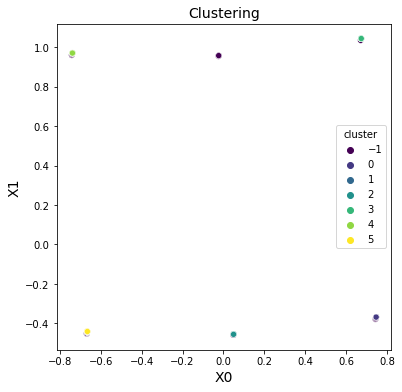

In [133]:
# set image size
plt.figure(figsize=(6, 6))
# set a title
plt.title("Clustering", fontdict={"fontsize": 14})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

In [134]:
#df.to_csv('cluster_profile_bach_DBSCAN.csv')

In [135]:
df.cluster.value_counts()

 0    169
 5    131
 3     68
 4     64
-1     60
 1     45
 2     30
Name: cluster, dtype: int64

In [136]:
cluster_0 = df.loc[df['cluster'] == 0]
cluster_0 = cluster_0[['id','interests','sex','city_title', 'years_old']]
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 1 to 3408
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          169 non-null    int64  
 1   interests   5 non-null      object 
 2   sex         169 non-null    int64  
 3   city_title  169 non-null    object 
 4   years_old   169 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.9+ KB


In [137]:
cluster_0.city_title.value_counts()

Saint Petersburg    169
Name: city_title, dtype: int64

In [138]:
cluster_0.sex.value_counts()

1    169
Name: sex, dtype: int64

In [139]:
cluster_0.years_old.describe()

count    169.000000
mean      29.366227
std       10.718768
min       15.925874
25%       20.227126
50%       26.308018
75%       35.920809
max       54.916408
Name: years_old, dtype: float64

In [140]:
cluster_5 = df.loc[df['cluster'] == 5]
cluster_5 = cluster_5[['id','interests','sex','city_title', 'years_old']]
cluster_5.describe()

,id,sex,years_old
count,1.310000e+02,131.0,131.000000
mean,3.453807e+08,1.0,21.052009
std,1.972278e+08,0.0,3.765357
min,1.116748e+07,1.0,14.849877
25%,1.931020e+08,1.0,18.618606
50%,3.578976e+08,1.0,19.977977
75%,4.986456e+08,1.0,22.561192
max,7.873195e+08,1.0,34.007012


In [141]:
cluster_5.city_title.value_counts()

Krasnoyarsk        6
Nizhny Novgorod    3
Vladivostok        3
Izhevsk            2
Tolyatti           2
Novosibirsk        2
Voronezh           2
Krasnodar          2
Tyumen             1
Samara             1
Chelyabinsk        1
Tomsk              1
Makeevka           1
Marina Gorka       1
Orenburg           1
Kashin             1
Salavat            1
Los Angeles        1
Kushva             1
Perm               1
Strelna            1
Zelenograd         1
Nikolskoe          1
Novorossiysk       1
Tula               1
Bryansk            1
Nevelsk            1
Yaroslavl          1
Barnaul            1
Minsk              1
Almetyevsk         1
Magnitogorsk       1
Kostroma           1
Rostov-on-Don      1
Syktyvkar          1
Vilnius            1
Kazan              1
Yekaterinburg      1
Vyborg             1
Kirov              1
Sochi              1
Novouralsk         1
Tashkent           1
Belgorod           1
Novocherkassk      1
Name: city_title, dtype: int64

In [142]:
cluster_5.sex.value_counts()

1    131
Name: sex, dtype: int64

In [143]:
cluster_5.years_old.describe()

count    131.000000
mean      21.052009
std        3.765357
min       14.849877
25%       18.618606
50%       19.977977
75%       22.561192
max       34.007012
Name: years_old, dtype: float64

In [148]:
cluster_1 = df.loc[df['cluster'] == 1]
cluster_1 = cluster_1[['id','interests','sex','city_title', 'years_old']]
cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45 entries, 41 to 3364
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          45 non-null     int64  
 1   interests   1 non-null      object 
 2   sex         45 non-null     int64  
 3   city_title  26 non-null     object 
 4   years_old   45 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.1+ KB


In [149]:
cluster_1.city_title.value_counts()

Novosibirsk      3
Murmansk         3
Aachen           1
Angarsk          1
Kemerovo         1
Tobolsk          1
Evpatoria        1
Krasnoyarsk      1
Tosno            1
Pskov            1
Koltsovo         1
Obninsk          1
Salavat          1
Izhevsk          1
Slantsy          1
Syktyvkar        1
Petergof         1
Sosnovy Bor      1
Lebyazhye        1
Vsevolozhsk      1
Rostov-on-Don    1
Penza            1
Name: city_title, dtype: int64

In [150]:
cluster_1.sex.value_counts()

1    45
Name: sex, dtype: int64

In [151]:
cluster_1.years_old.describe()

count    45.000000
mean     46.186926
std       3.880075
min      37.946860
25%      43.337799
50%      45.859412
75%      48.824565
max      55.852772
Name: years_old, dtype: float64

In [152]:
cluster_4 = df.loc[df['cluster'] == 4]
cluster_4 = cluster_4[['id','interests','sex','city_title', 'years_old']]
cluster_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 411 to 3428
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          64 non-null     int64  
 1   interests   1 non-null      object 
 2   sex         64 non-null     int64  
 3   city_title  31 non-null     object 
 4   years_old   64 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.0+ KB


In [153]:
cluster_4.city_title.value_counts()

Novosibirsk      2
Izhevsk          2
Sosnovy Bor      1
Berlin           1
Gai              1
Alger            1
Khabarovsk       1
Tula             1
Vologda          1
Tashkent         1
Petergof         1
Ulyanovsk        1
Odessa           1
Krasnodar        1
Tomsk            1
Vyborg           1
Warszawa         1
Little Tokyo     1
Cherepovets      1
Voronezh         1
Minsk            1
Yekaterinburg    1
Smolensk         1
Belgorod         1
Tbilisi          1
Kazan            1
Omsk             1
Perm             1
Alexandria       1
Name: city_title, dtype: int64

In [154]:
cluster_4.sex.value_counts()

2    64
Name: sex, dtype: int64

In [155]:
cluster_4.years_old.describe()

count    64.000000
mean     21.874576
std       3.827909
min      15.808144
25%      19.166187
50%      21.082722
75%      23.085501
max      32.764002
Name: years_old, dtype: float64

In [156]:
cluster_11 = df.loc[df['cluster'] == -1]
cluster_11 = cluster_11[['id','interests','sex','city_title', 'years_old']]
cluster_11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 28 to 3354
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          60 non-null     int64  
 1   interests   3 non-null      object 
 2   sex         60 non-null     int64  
 3   city_title  49 non-null     object 
 4   years_old   60 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ KB


In [157]:
cluster_11.city_title.value_counts()

Saint Petersburg            16
Moscow                      15
Syktyvkar                    2
Stavropol                    1
Ufa                          1
Blagoveschensk               1
Novosibirsk                  1
Petergof                     1
Yekaterinburg                1
Petropavlovsk-Kamchatsky     1
Minsk                        1
Brest                        1
Perm                         1
Tolyatti                     1
Borovichi                    1
Chita                        1
Almaty                       1
Chelyabinsk                  1
Ulyanovsk                    1
Name: city_title, dtype: int64

In [158]:
cluster_11.sex.value_counts()

2    33
1    27
Name: sex, dtype: int64

In [159]:
cluster_11.years_old.describe()

count     60.000000
mean      65.499103
std       31.941486
min       17.642542
25%       44.333713
50%       57.610508
75%       99.756480
max      121.926682
Name: years_old, dtype: float64

In [160]:
cluster_2 = df.loc[df['cluster'] == 2]
cluster_2 = cluster_2[['id','interests','sex','city_title', 'years_old']]
cluster_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 124 to 3327
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          30 non-null     int64  
 1   interests   1 non-null      object 
 2   sex         30 non-null     int64  
 3   city_title  30 non-null     object 
 4   years_old   30 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.4+ KB


In [161]:
cluster_2.city_title.value_counts()

Moscow    30
Name: city_title, dtype: int64

In [162]:
cluster_2.sex.value_counts()

1    30
Name: sex, dtype: int64

In [163]:
cluster_2.years_old.describe()

count    30.000000
mean     23.725259
std       4.135546
min      17.623377
25%      20.119663
50%      22.476317
75%      27.492847
max      32.241062
Name: years_old, dtype: float64

In [164]:
cluster_3 = df.loc[df['cluster'] == 3]
cluster_3 = cluster_3[['id','interests','sex','city_title', 'years_old']]
cluster_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 3 to 3386
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          68 non-null     int64  
 1   interests   4 non-null      object 
 2   sex         68 non-null     int64  
 3   city_title  68 non-null     object 
 4   years_old   68 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.2+ KB


In [165]:
cluster_3.city_title.value_counts()

Saint Petersburg    68
Name: city_title, dtype: int64

In [166]:
cluster_3.sex.value_counts()

2    68
Name: sex, dtype: int64

In [167]:
cluster_3.years_old.describe()

count    68.000000
mean     23.800739
std       5.388865
min      16.029915
25%      20.084071
50%      21.659052
75%      26.273794
max      38.108397
Name: years_old, dtype: float64